# Predict low high models
Model selection for predict lo hi


To install conda and binance packages to this notebook uncomment the code below

In [1]:
#%conda install -c plotly plotly=5.9.0
#%conda install pip
#%conda install twisted
%pip install plotly==5.9.0
%pip install twisted
#%pip install binance-connector==1.13.0
%pip install pandas
%pip install scikit-learn
%pip install tensorflow==2.11.0
%pip install keras==2.11.0
%pip install scikeras


import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable


Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


## Feature engineering
Read data from bot's history, resample to equal intervals, create X, y

In [2]:
import os
import glob
import pandas as pd
from datetime import timedelta,date

def read_last_data(strategy, days=1):
    """ Read last last day from bot history """
    
    def read_last(symbol: str, name: str, days=1):
        data_dir=f"./../data/{strategy}/Xy"
        file_paths = sorted([f"{data_dir}/{f}" for f in os.listdir(data_dir) if f.endswith(f"{symbol}_{name}.csv")])[-days:]
        return pd.concat([pd.read_csv(f, parse_dates=True, index_col="datetime") for f in file_paths])

    data=read_last("BTCUSDT", "data", days)
    X=read_last("BTCUSDT", "X", days)
    y=read_last("BTCUSDT", "y", days)
    return data,X,y

#strategy="SimpleKerasStrategy"
strategy="LSTMStrategy"
bidask,X_bot,y_bot = read_last_data(strategy, days=1)
bidask

,symbol,bid,bid_vol,ask,ask_vol
datetime,,,,,
2023-05-05 23:59:51.713772,BTCUSDT,29483.22,6.32275,29483.23,0.00064
2023-05-05 23:59:52.125970,BTCUSDT,29483.22,5.98348,29483.23,0.00064
2023-05-05 23:59:52.541282,BTCUSDT,29483.22,5.64421,29483.23,0.00064
2023-05-05 23:59:52.949466,BTCUSDT,29483.22,5.98348,29483.23,0.00064
2023-05-05 23:59:53.361240,BTCUSDT,29483.22,6.32261,29483.23,0.00064
...,...,...,...,...,...
2023-05-06 18:24:29.009469,BTCUSDT,28833.65,0.00036,28833.66,0.69382
2023-05-06 18:24:29.471576,BTCUSDT,28833.65,0.00036,28833.66,1.04067
2023-05-06 18:24:29.921714,BTCUSDT,28833.65,0.00036,28833.66,1.07792


Resample data to use equal time intervals

In [3]:
import re
def get_targets(bidask, predict_window="10s"):
    """ 
    Calculate targets - bid/ask bounds in future prediction window
    """
    fut_min=bidask[["bid", "ask"]][::-1].rolling(predict_window).min()[::-1].rename(columns={"bid":"bid_min_fut", "ask":"ask_min_fut"})
    fut_max=bidask[["bid", "ask"]][::-1].rolling(predict_window).max()[::-1].rename(columns={"bid":"bid_max_fut", "ask":"ask_max_fut"})
    return pd.concat([fut_min, fut_max], axis = 1)
    
def resampled(X: pd.DataFrame, y: pd.DataFrame, time_interval) -> (pd.DataFrame, pd.DataFrame):
    """ Resample to make equal intervals time series """
    if int(re.sub(r'\D', "", time_interval)) == 0:
        return X, y
    Xy=pd.concat([X,y], axis=1)
    diffmap = [(c, "sum") for c in Xy.columns if c.endswith("diff")]
    timemap = [(c, "last") for c in Xy.columns if c.startswith("time") and not c.endswith("diff")]
    l2map = [(c, "last") for c in Xy.columns if c.startswith("l2_")]
    
    futmap = [(c, "last") for c in Xy.columns if c.endswith("_fut")]
    colmap = dict(diffmap + timemap + l2map + futmap + [("spread", "last")])
    resampled = Xy.resample(time_interval).agg(colmap).dropna()
    return resampled[X.columns], resampled[y.columns]

predict_window="10s"
resample_interval="0s"
y_raw = get_targets(bidask, predict_window)
X,y = resampled(X_bot, y_raw, resample_interval)
#X,y=X_bot,y_raw
pd.concat([X,y], axis=1).dropna()

,time_hour,time_minute,time_second,time_day_of_week,time_diff,spread,bid_diff,bid_vol_diff,ask_diff,ask_vol_diff,l2_bucket_-10,l2_bucket_-9,l2_bucket_-8,l2_bucket_-7,l2_bucket_-6,l2_bucket_-5,l2_bucket_-4,l2_bucket_-3,l2_bucket_-2,l2_bucket_-1,l2_bucket_0,l2_bucket_1,l2_bucket_2,l2_bucket_3,l2_bucket_4,l2_bucket_5,l2_bucket_6,l2_bucket_7,l2_bucket_8,l2_bucket_9,bid_min_fut,ask_min_fut,bid_max_fut,ask_max_fut
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-05-05 23:59:51.713772,23,59,51,4,433897000.0,0.01,0.0,0.08000,0.0,0.00000,0.00082,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.23266,17.15450,8.76429,0.225,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29483.22,29483.23,29483.52,29483.53
2023-05-05 23:59:52.125970,23,59,52,4,412198000.0,0.01,0.0,-0.33927,0.0,0.00000,0.00082,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.23266,17.15450,8.76429,0.225,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29483.22,29483.23,29483.52,29483.53
2023-05-05 23:59:52.541282,23,59,52,4,415312000.0,0.01,0.0,-0.33927,0.0,0.00000,0.00082,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.23266,17.15450,8.76429,0.225,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29483.22,29483.23,29483.52,29483.53
2023-05-05 23:59:52.949466,23,59,52,4,408184000.0,0.01,0.0,0.33927,0.0,0.00000,0.00082,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.23266,17.15450,8.76429,0.225,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29483.22,29483.23,29483.52,29483.53
2023-05-05 23:59:53.361240,23,59,53,4,411774000.0,0.01,0.0,0.33913,0.0,0.00000,0.00082,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.23266,17.15450,8.76429,0.225,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29483.22,29483.23,29483.52,29483.53
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-06 18:24:29.009469,18,24,29,5,468128000.0,0.01,0.0,0.00000,0.0,0.34691,0.00083,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.97737,6.26333,4.41358,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28833.65,28833.66,28833.65,28833.66
2023-05-06 18:24:29.471576,18,24,29,5,462107000.0,0.01,0.0,0.00000,0.0,0.34685,0.00083,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.97737,6.26333,4.41358,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28833.65,28833.66,28833.65,28833.66
2023-05-06 18:24:29.921714,18,24,29,5,450138000.0,0.01,0.0,0.00000,0.0,0.03725,0.00083,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.97737,6.26333,4.41358,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28833.65,28833.66,28833.65,28833.66


## Create the model


Train size: 152312
Epoch 1/5
1/1 [==============================] - 7s 7s/step - loss: 0.0861 - mae: 0.2826 - val_loss: 0.4282 - val_mae: 0.6026
Epoch 2/5
1/1 [==============================] - 4s 4s/step - loss: 0.0874 - mae: 0.2816 - val_loss: 0.5604 - val_mae: 0.7032
Epoch 3/5
1/1 [==============================] - 4s 4s/step - loss: 0.2396 - mae: 0.4772 - val_loss: 0.6845 - val_mae: 0.7862
Epoch 4/5
1/1 [==============================] - 4s 4s/step - loss: 0.0909 - mae: 0.2789 - val_loss: 0.7250 - val_mae: 0.8112
Epoch 5/5
1/1 [==============================] - 4s 4s/step - loss: 0.1643 - mae: 0.3920 - val_loss: 0.7957 - val_mae: 0.8532


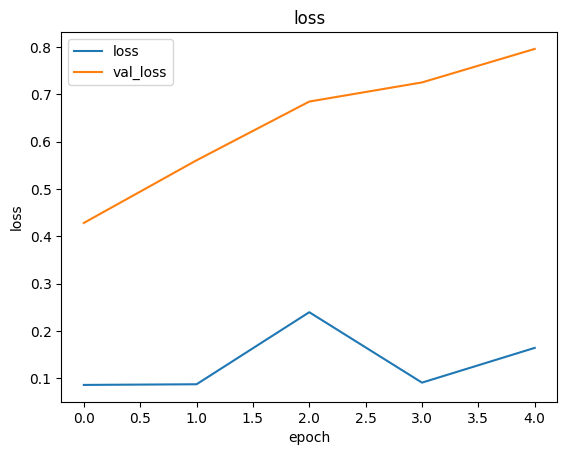

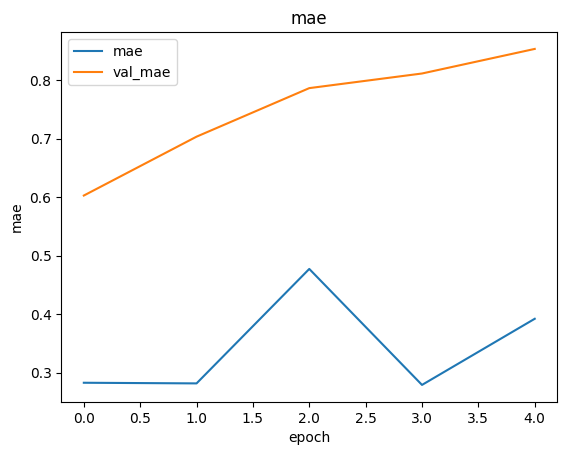

In [18]:
from keras import Sequential, Input
from keras.layers import Dense, Dropout
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from scikeras.wrappers import KerasRegressor
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.compose import ColumnTransformer, make_column_selector
import matplotlib.pyplot as plt
import tensorflow as tf


  
def create_model(X_train, y_train, window_size):
    model = Sequential()
    model.add(LSTM(128,  return_sequences=True, input_shape=(window_size, X_train.shape[1])))
    model.add(Dropout(0.2))
    model.add(LSTM(32))         
    model.add(Dropout(0.2))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(y_train.shape[1], activation='linear'))
    #model.add(Dense(y_train.shape[1], activation='softmax'))
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    #model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mean_squared_error'])
    #model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mean_squared_error'])
    #model.compile(optimizer='adam', loss=tf.keras.losses.Huber(), metrics=['mean_squared_error'])
    return model


def plot_history(history):
    """ Plot history loss and metrics"""
    # summarize history for accuracy
    for metric_name in history.history:
        # validation metrics names will be calculated from related train metrics
        if metric_name.startswith("val_"): continue

        # Plot metric and related test (val_..) metric
        names=[metric_name, f"val_{metric_name}"]
        for name in names:
            plt.plot(history.history[name])
        # Captions and show the plot
        plt.title(metric_name)
        plt.ylabel(metric_name)
        plt.xlabel('epoch')
        plt.legend(names, loc='upper left')
        plt.show()

test_size=0.3
test_index = int(len(X)*(1-test_size))
X_train, y_train, X_test, y_test = X.iloc[:test_index], y.iloc[:test_index], X.iloc[test_index:], y.iloc[test_index:]


# Train/test split    
x_pipe = Pipeline(
    [("xrs", RobustScaler()),
     ("xmms", MinMaxScaler())])
x_pipe.fit(X_train)

y_pipe = Pipeline(
    [("yrs", RobustScaler()),
     ("ymms",MinMaxScaler())])
y_pipe.fit(y_train)

#x_scaler, y_scaler = MinMaxScaler().fit(X_train), MinMaxScaler().fit(y_train)
X_train, y_train = x_pipe.transform(X_train), y_pipe.transform(y_train)
X_test, y_test = x_pipe.transform(X_test), y_pipe.transform(y_test)
print(f"Train size: {X_train.shape[0]}")


# Create the model
window_size = 15
model = create_model(X_train, y_train, window_size)

# Fit the model
epochs=5
steps_per_epoch=5
train_gen = TimeseriesGenerator(X_train, y_train, length=window_size)
test_gen = TimeseriesGenerator(X_test, y_test, length=window_size)
history=model.fit(train_gen, validation_data=test_gen, epochs=epochs, steps_per_epoch=steps_per_epoch)

# Plot the result
plot_history(history)
